# Welcome to Computer Vision! #

<!-- TODO: lede -->

<!-- TODO: HEADER ILLUSTRATION -->

In this micro-course, you'll:
- Use modern deep-learning networks to build an **image classifier** with Keras!
- Design your own **custom convnet** with reusable blocks!
- Master the art of **transfer learning** to boost your models!
- Utilize **data augmentation** to extend a dataset--for free!
- Learn the fundamentals of **convolution** and **pooling** so you can go even further!

If you've taken the *Introduction to Deep Learning* micro-course, you'll know everything you need to be successful.

Now let's get started!

# Introduction #

This course will introduce you to the fundamental ideas of computer vision. Our goal is to learn how a neural network can "understand" a natural image well-enough to solve the same kinds of problems the human visual system can solve.

The neural networks that are best at this task are called **convolutional neural networks** (Sometimes we say **convnet** or **CNN** instead.) Convolution is the mathematical operation these networks use in their layers that give them a structure different from the dense layers you learned about in the introductory course. In future lessons, you'll learn why this structure is so effective at solving computer vision problems.

The ideas in this course are important to any kind of computer vision problem. We will apply them to the problem of **image classification**. At the end, however, you'll be prepared for other topics in computer vision like image segmentation and GANs.

# The Convolutional Classifier #

A convnet used for image classification consists of two parts: a **convolutional base** and a **dense head**.

<!-- ![The parts of a convnet: image, base, head, class; input, extract, classify, output.](./images/1-parts-of-a-convnet.png "The parts of a convnet.") -->

<img src="./images/1-parts-of-a-convnet.png" width="600" alt="The parts of a convnet: image, base, head, class; input, extract, classify, output.">

The base is used to **extract the features** from an image. It is formed primarily of layers performing the convolution operation, but often includes other kinds of layers as well. (You'll learn about these in the next lesson.)

The head is used to **determine the class** of the image. It is formed primarily of dense layers, but might include other layers like dropout. 

What do we mean by visual feature? A feature could be a line, a color, a texture, a shape, a pattern -- or some complicated combination.

The whole process goes something like this:

<!-- TODO: extract -> classify -->

The features actually extracted aren't quite like this, but it gives the idea.

# Training the Classifier #

The goal of the network during training is to learn two things:
1. which features to extract from an image (base),
2. which class goes with what features (head).

These days, convnets are rarely trained from scratch. More often, we **reuse the base of a pretrained model**, that is, a model already trained on some similar dataset.

To this pretrained base we then **attach an untrained head**. Because the base has already learned to extract useful features, we then only need to train the head to classify the images in the new dataset.

<img src="./images/1-attach-head-to-base.png" width="400" alt="Attaching a new head to a trained base.">

Because the head usually consists of only a few dense layers, very accurate classifiers can be created from relatively little data.

# Example - Train a Convnet Classifier #

Let's walk through an example. Our goal is to create a classifier for the `Stanford Cars` dataset. It consists of about 16,000 images in 196 classes. The steps are basically the same as you learned about in the introductory course.

## Step 1 - Load Data ##

In [3]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [9]:
# Imports
import visiontools
from visiontools import StanfordCars
import tensorflow as tf
import tensorflow_datasets as tfds

# Load training and validation sets
DATA_DIR = '/kaggle/input/stanford-cars-for-learn/'
(ds_train, ds_valid), ds_info = tfds.load('stanford_cars/simple',
                                          split=['train', 'test'],
                                          shuffle_files=True,
                                          with_info=True,
                                          data_dir=DATA_DIR)
print(("Loaded {} training examples " +
       "and {} validation examples " +
       "with classes {}.").format(
           ds_info.splits['train'].num_examples,
           ds_info.splits['test'].num_examples,
           ds_info.features['label'].names))

# Create data pipeline
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
SIZE = [192, 192]
preprocess = visiontools.make_preprocessor(size=SIZE)

ds_train_ = (ds_train.map(preprocess)
             .cache()
             .shuffle(ds_info.splits['train'].num_examples)
             .batch(BATCH_SIZE)
             .prefetch(AUTO))

ds_valid_ = (ds_valid.map(preprocess)
             .cache()
             .batch(BATCH_SIZE)
             .prefetch(AUTO))

The first step is to prepare your dataset. We've already preloaded a training split `ds_train` and a validation split `ds_valid`, so let's skip the details of loading data for now and look at a few examples in the training split.

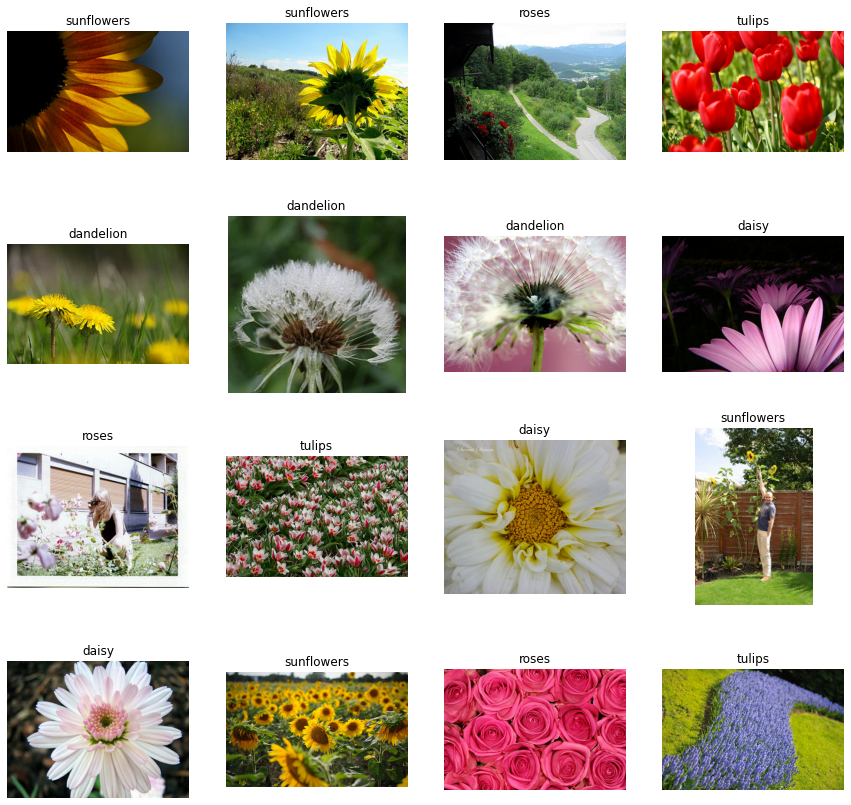

In [10]:
#$HIDE$
visiontools.show_supervised_examples(ds_train, ds_info);

## Step 2 - Define Pretrained Base ##

The pretrained model we'll use is called **VGG16**. 

In [5]:
from tensorflow.keras.applications import VGG16

pretrained_base = VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=[*IMG_SIZE, 3])
pretrained_base.trainable = False

## Step 3 - Attach Head ##

In [10]:
from tensorflow.keras import Sequential
import tensorflow.keras.layers as layers

model = Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

## Step 4 - Train ##

In [11]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(ds_train,
                    validation_data=ds_valid,
                    epochs=10)

Epoch 1/15
86/86 [==============================] - 10s 119ms/step - loss: 1.1985 - sparse_categorical_accuracy: 0.6577 - val_loss: 0.4469 - val_sparse_categorical_accuracy: 0.8464
Epoch 2/15
86/86 [==============================] - 10s 114ms/step - loss: 0.4306 - sparse_categorical_accuracy: 0.8550 - val_loss: 0.2892 - val_sparse_categorical_accuracy: 0.9139
Epoch 3/15
86/86 [==============================] - 10s 115ms/step - loss: 0.2879 - sparse_categorical_accuracy: 0.9070 - val_loss: 0.2148 - val_sparse_categorical_accuracy: 0.9346
Epoch 4/15
86/86 [==============================] - 10s 116ms/step - loss: 0.2655 - sparse_categorical_accuracy: 0.9070 - val_loss: 0.3031 - val_sparse_categorical_accuracy: 0.8725
Epoch 5/15
86/86 [==============================] - 10s 118ms/step - loss: 0.2763 - sparse_categorical_accuracy: 0.8895 - val_loss: 0.3225 - val_sparse_categorical_accuracy: 0.8747
Epoch 6/15
86/86 [==============================] - 10s 118ms/step - loss: 0.2698 - sparse_cate

## Step 5 - Evaluate ##

When training a neural network, it's always a good idea to examine the loss and metric plots. The `history` object contains this information in a dictionary `history.history`. We can use Pandas to convert this dictionary to a dataframe and plot it with a built-in method.

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot();

<!-- discuss convergence, over/underfitting -->

# Conclusion #

In this lesson, we learned about the structure of a convnet classifier: a **head** to act as a classifier atop of a **base** which performs the feature extraction.

The head, essentially, is an ordinary classifier like you learned about in the introductory course. For features, it uses those features extracted by the base. This is the basic idea behind CNN image classifiers: that we can attach a unit that performs feature engineering to the classifier itself.

This is one of the big advantages deep neural networks have over traditional machine learning models: given the right network structure, the deep neural net can learn how to engineer the features it needs to solve its problem.

In the remainder of this micro-course, we're going to explore this convolutional base.